In [1]:
# 1. Import Libraries
from google.colab import drive
import os
import numpy as np

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the Animal_species folder
base_dir = '/content/drive/MyDrive/Animal_species_split'

# Verify the contents of the Animal_species folder
print("Contents of the Animal_species folder:")
print(os.listdir(base_dir))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of the Animal_species folder:
['train', 'validation', 'test']


In [3]:
# get the class names programmatically
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/Animal_species_split/train') # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['buffalo' 'elephant' 'rhino' 'zebra']


In [4]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = os.path.join(target_dir, target_class)

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)[0]

  if random_image.lower().endswith(('.png', '.jpg', '.jpeg')):

    print(f"Random image: {random_image}")

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image)
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img
  else:
    print(f"Not an image, Please run the cell again")

In [5]:
# View a random image from the training dataset
img = view_random_image(target_dir="/content/drive/MyDrive/Animal_species_split/train/",
                        target_class="buffalo")

Not an image, Please run the cell again


In [6]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/drive/MyDrive/Animal_species_split/train/"
test_dir = "/content/drive/MyDrive/Animal_species_split/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 1052 images belonging to 4 classes.
Testing images:
Found 160 images belonging to 4 classes.


In [7]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating our model using transfer learing from tensorflowhub
Our transfer learning model was gotten from: https://tfhub.dev/

Resnet: https://www.kaggle.com/models/google/resnet-v2




In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# Resnet 50 V2 feature vector
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/TensorFlow2/101-classification/2"

In [10]:

def create_model(model_url, num_classes=4):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Creating our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [11]:
# Create model
resnet_model = create_model(resnet_url, num_classes=4)

# Compile
resnet_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [12]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240523-220555
Epoch 1/5
33/33 [==============================] - 384s 11s/step - loss: 0.3924 - accuracy: 0.8707 - val_loss: 0.1375 - val_accuracy: 0.9563
Epoch 2/5
33/33 [==============================] - 393s 12s/step - loss: 0.1098 - accuracy: 0.9648 - val_loss: 0.1401 - val_accuracy: 0.9625
Epoch 3/5
33/33 [==============================] - 394s 12s/step - loss: 0.0816 - accuracy: 0.9791 - val_loss: 0.0965 - val_accuracy: 0.9688
Epoch 4/5
33/33 [==============================] - 385s 12s/step - loss: 0.0620 - accuracy: 0.9857 - val_loss: 0.0973 - val_accuracy: 0.9625
Epoch 5/5
33/33 [==============================] - 357s 11s/step - loss: 0.0514 - accuracy: 0.9857 - val_loss: 0.0919 - val_accuracy: 0.9688


In [13]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

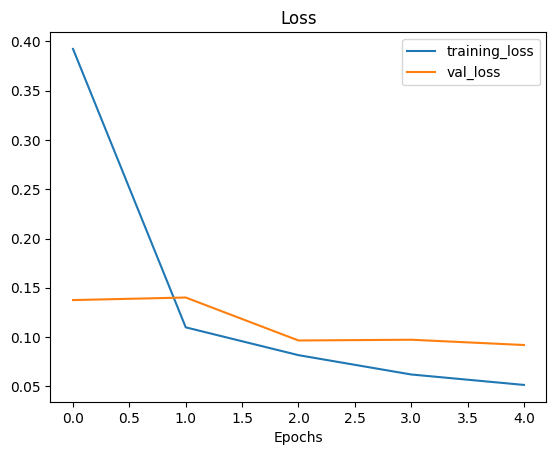

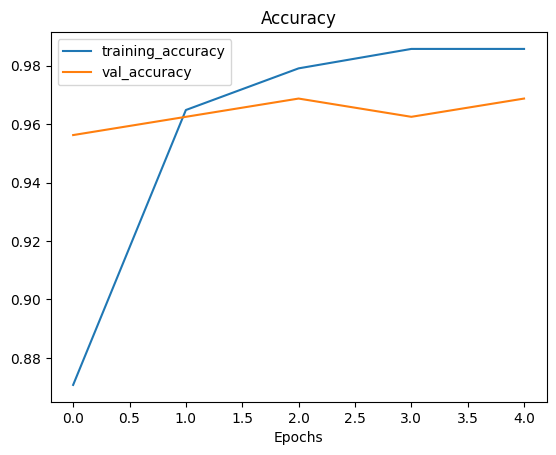

In [14]:
plot_loss_curves(resnet_history)

In [15]:
# Resnet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1001)              44677609  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 4)                 4008      
                                                                 
Total params: 44681617 (170.45 MB)
Trainable params: 4008 (15.66 KB)
Non-trainable params: 44677609 (170.43 MB)
_________________________________________________________________


In [16]:
pred_prob = resnet_model.evaluate(test_data, verbose=1);

5/5 [==============================] - 46s 9s/step - loss: 0.0919 - accuracy: 0.9688
